Interesting recent GPU benchmarks (2022) which show the 1080Ti at about 1/5 the speed of the latest tech:

https://lambdalabs.com/gpu-benchmarks

In [1]:
# installing/upgrading fastai2 
!pip install --upgrade fastai

In [20]:
%matplotlib inline
from fastai import *
from fastai.vision import *
from fastai.vision.all import *

torch.backends.cudnn.benchmark = True

In [21]:
# Test to ensure that my cuda is still visible
import torch as torch
torch.cuda.is_available()

True

Switching to CPU to see how things go...
Hmmm, these settings were supposed to work, but the GPU was still being used.
Switching to the default Python kernel which should not have GPU suppport.

In [22]:
torch.device("cpu")
default_device(-1)
defaults.device = 'cpu'
# torch.cuda.device(0) to select the first GPU (and only GPU on my system)
torch.cuda.current_device()

0

In [39]:
%%timeit -n 1 -r 1
torch.cuda.get_device_name(0)

28.1 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [24]:
cpu = torch.device("cpu")

In [25]:
path = untar_data(URLs.CIFAR)
path

Path('C:/Users/ron-w/.fastai/data/cifar10')

In [26]:
bs = 256

In [31]:
ds_tfms = ([OldRandomCrop(4, 32), FlipItem(p=0.5)], [])
data = ImageDataLoaders.from_folder(path, valid='test', item_tfms=ds_tfms, bs=bs)

In [28]:
# This seems to do the trick--finally am not seeing any action on the GPU.  Of course, 
#data.to(cpu)


In [32]:
learn = Learner(data, xresnet152(pretrained=True).to("cpu"), metrics=accuracy)
#learn.to(cpu)

**Fit One Cycle**
Good info on fit_one_cycle: https://iconof.com/1cycle-learning-rate-policy/
https://sgugger.github.io/the-1cycle-policy.html
https://fastai.github.io/fastbook2e/accel_sgd.html

Changed the model to xresnet152, and using pretrained=True, 15 epochs, adding momentum

SuggestedLRs(valley=0.0003981071640737355)

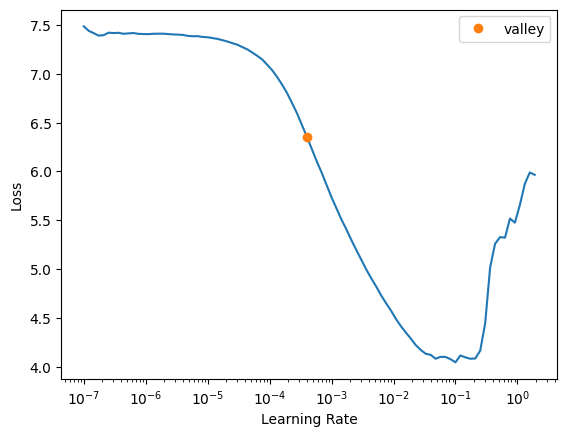

In [34]:
# Commented out the 'to(cpu)' calls in previous cells. 
# lr_find takes less than 50 seconds to complete when it defaults to my GPU
# It was pegging my CPU, at 25% done, and had taken 5+ minutes. 
# Not completely fair to compare, but that would be about 25x speed difference
# Running too slow on the CPU to try longer tests!
learn.lr_find()

In [37]:
learn.fit_one_cycle(15, 0.000575439, wd=0.4, div=10, pct_start=0.5)

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 